Pitanja:

1. Da li biramo 10 obeležja pre ili posle analize (ispitivanje korelacija i IG), sa kojim setom obeležja se nastavlja dalje - da li postoji striktan način odabira?
2. Da li je godište donora validan fičer jer se ispostavlja da on ima baš veliku informacionu dobit + šta da radimo sa survival_time_numeric, nije baš fer fičer haha

In [185]:
# učitavanje biblioteka 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# 1. Učitavanje baze i analiza podataka

In [186]:
data = pd.read_csv('03_bone_marrow_dataset.csv')
print(data.shape)

(187, 37)


In [187]:
# brišemo razmak na kraju naziva atributa (lakše je za kasniju analizu)
for attribute in data.columns:
    if(attribute[-1] == ' '):
        data.rename(columns = {attribute:attribute[0:-1]}, inplace = True)
attributes = data.columns
data

,Recipientgender,Stemcellsource,Donorage numeric,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6 numeric,CD3dCD34 numeric,CD3dkgx10d8 numeric,Rbodymass numeric,ANCrecovery numeric,PLTrecovery numeric,time_to_aGvHD_III_IV numeric,survival_time numeric,survival_status numeric
0,1,1,22.830137,0,1,0,1,1,1,0,...,1,7.20,1.33876,5.38,35,19,51,32,999,0
1,1,0,23.342466,0,1,0,-1,-1,1,0,...,1,4.50,11.078295,0.41,20.6,16,37,1000000,163,1
2,1,0,26.394521,0,1,0,-1,-1,1,0,...,1,7.94,19.01323,0.42,23.4,23,20,1000000,435,1
3,0,0,39.684932,1,1,0,1,2,1,1,...,?,4.25,29.481647,0.14,50,23,29,19,53,1
4,0,1,33.358904,0,0,0,1,2,0,1,...,1,51.85,3.972255,13.05,9,14,14,1000000,2043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,37.575342,1,1,0,1,1,0,0,...,1,11.08,2.52275,4.39,44,15,22,16,385,1
183,0,1,22.895890,0,0,0,1,0,1,1,...,1,4.64,1.038858,4.47,44.5,12,30,1000000,634,1
184,0,1,27.347945,0,1,0,1,-1,1,1,...,1,7.73,1.635559,4.73,33,16,16,1000000,1895,0
185,1,1,27.780822,0,1,0,1,0,1,1,...,0,15.41,8.07777,1.91,24,13,14,54,382,1


Podaci koji se nalaze u bazi:       

1. Recipientgender - pol pacijenta: 0 ili 1    
2. Stemcellsource - izvor ćelija (kvr ili koštana srž): 0 ili 1
3. Donorage numeric - broj godina donora: float num 18.646575 - 55.553425
4. Donorage35 - da li je starost donora manja od 35 godina: 0 ili 1
5. IIIV - razvoj bolesti transplantata 3. ili 4. stepena: 0 ili 1 
6. Gendermatch - kompatibilnost donora i promaoca po polu: 0 ili 1
7. DonorABO - krvna grupa donora: -1, 0, 1, 2
8. <font color=red>RecipientABO - krvna grupa pacijenta: -1, 0, 1, 2</font>
9. <font color=red>RecipientRh - da li pacijent ima Rh raktor: 0 ili 1</font>
10. <font color=red>ABOmatch - kompatibilnost pacijenta i donora po krvnoj grupi: 0 ili 1</font>
11. <font color=red>CMVstatus - kompatibilnost pacijenta i donora prema citomegalo virusu koji se može razviti (što je veća kompatibilnost to je lošije po pacijenta): num 0, 1, 2, 3 i ? </font>
12. <font color=red>DonorCMV - postojanje citomegalo virusne infekcije kod donora pre transplantacije: 0 ili 1 </font>
13. <font color=red>RecipientCMV - postojanje citomegalo virusne infekcije kod pacijenta pre transplantacije: 0 ili 1 </font>
14. Disease - vrsta bolesti: ALL, AML, chronic, nonmalignant, lymphoma
15. Riskgroup - rizična grupa: 0 ili 1
16. Txpostrelapse - da li je rađena druga transplantacija nakon što je prva prošla loše: 0 ili 1
17. Diseasegroup - da li je oboljenje maligno ili nije: 0 ili 1
18. HLAmatch - grupe antigena donora i primaoca: 0, 1, 2, 3
19. HLAmismatch - da li su se antigeni poklopili: 0 ili 1
20. <font color=red>Antigen - u koliko antigena postoji razlika između donora i pacijenta: -1, 0, 1, 2 i ?</font>
21. <font color=red>Alel - u koliko allela postoji razlika između donora i pacijenta: -1, 0, 1, 2, 3, ?</font>
22. HLAgrI - razlika između donora i primaoca u parametrima kao što su antigen, alel, HLA, itd: 0, 1, 2, 3, 4, 5, 6, 7
23. Recipientage numeric - starost pacijenta u trenutku transplantacije: 0.6 - 20.2
24. Recipientage10 - da li je starost pacijenta manja od 10 godina: 0 ili 1 
25. Recipientageint - godište pacijenta diskretizovano po intervalima: 0, 1, 2
26. Relapse - povratak bolesti: 0 ili 1
27. aGvHDIIIIV - da li se razvila neka bolest 3. i 4. stepena: 0 ili 1
28. <font color=red>extcGvHD - da li se razvila neka bolest 3. i 4. stepena: 0, 1 i ?</font>
29. CD34kgx10d6 numeric - doza neke vrste ćelija skalirana po težini čoveka: float 0.79 - 57.78 
30. <font color=red>CD3dCD34 numeric - doza druge vrste ćelija skalirana po dozi druge vrste: float 0 - 99.56097 i ?</font>
31. <font color=red>CD3dkgx10d8 numeric - doza neke vrste ćelija skalirana po težini čoveka: float 0 - 20.02 i ?</font>
32. <font color=red>Rbodymass numeric - bodymass indeks pacijenta: float 0 - 103.4 i ?</font>
33. ANCrecovery numeric - oporavak neutrofila definisan kao njihov broj (>0.5 je da) : float 9 - 26.0 i 1000000.0
34. PLTrecovery numeric - oporavak trombocita definisam njihov broj (>50000 da): float 9 - 285 i 1000000.0 
35. time_to_aGvHD_III_IV numeric - vreme u danima proteklo do razvoja akutne bolesti transplantata 3. ili 4. stepena: 10 - 100 i 1000000
36. survival_time numeric - vreme posmatranja (u slučaju živog pacijenta) ili vreme do smrti: 6 - 3364
37. survival_status numeric - da li je osoba živa ili mrtva: 0 ili 1


In [188]:
print(set(data.dtypes))
data.dtypes[data.dtypes == 'O']

{dtype('int64'), dtype('float64'), dtype('O')}


RecipientABO           object
RecipientRh            object
ABOmatch               object
CMVstatus              object
DonorCMV               object
RecipientCMV           object
Disease                object
Antigen                object
Alel                   object
extcGvHD               object
CD3dCD34 numeric       object
CD3dkgx10d8 numeric    object
Rbodymass numeric      object
dtype: object

U tabeli se nalaze vrednosti koje nisu samo numeričke ( int / float ).     
Potrebno je proveriti da li neke kolone koje imaju više tipova podataka (njihov tip je object) sadrže i nepostojeće vrednosti (obeležene su sa "?" npr). Kolone koje sadrže neprihvaćene vrednosti su u podacima obeležene crvenom bojom.

#### Sređivanje podataka

Ni u jednoj klasi fičera ne nedostaje veliki broj vrednosti, tako da se sve one nevalidne menjaju vrednosti sa nejvećim brojem ponavljanja

In [189]:
# return the most frequent character in the column
def find_mod(col):
    return Counter(data[col][data[col]!='?']).most_common(1)[0][0]

In [190]:
# zamena vrednosti '?' medianom
data['ABOmatch'] = data['ABOmatch'].replace('?', int(find_mod('ABOmatch')))
data['CMVstatus'] = data['CMVstatus'].replace('?', int(find_mod('CMVstatus')))
data['DonorCMV'] = data['DonorCMV'].replace('?', int(find_mod('DonorCMV')))
data['RecipientCMV'] = data['RecipientCMV'].replace('?', int(find_mod('RecipientCMV')))
data['Antigen'] = data['Antigen'].replace('?', int(find_mod('Antigen')))
data['Alel'] = data['Alel'].replace('?', int(find_mod('Alel')))
data['extcGvHD'] = data['extcGvHD'].replace('?', int(find_mod('extcGvHD')))
data['Rbodymass numeric'] = data['Rbodymass numeric'].replace('?', float(find_mod('Rbodymass numeric')))

Ovde bi valjalo da prođemo još jednom zajedno. Ti si zamenila sve nedostajuće vrednosti modom. Međutim imamo neka obeležja koja nisu kategoričke vrednosti pa baš i nema smisla da kontinualnu nedostajuću vrednost zamenimo najčešćom, već treba da je zamenimo medijanom

In [199]:
cols_mod = ["RecipientABO", "RecipientRh"]
data[cols_mod] = data[cols_mod].replace('?', pd.DataFrame.mode(data[cols_mod]).iloc[0])


cols_median = ["CD3dCD34 numeric", "CD3dkgx10d8 numeric"]
data[cols_median] = data[cols_median].replace('?', np.nan)
data[cols_median] = data[cols_median].fillna(data[cols_median].median())


Svi podaci koji su brojevi a predstavljeni su kao string u bazi se konvertuju u odgovarajući tip podataka

In [200]:
data['RecipientABO'] = data['RecipientABO'].astype('int64')
data['RecipientRh'] = data['RecipientRh'].astype('int64')
data['ABOmatch'] = data['ABOmatch'].astype('int64')
data['CMVstatus'] = data['CMVstatus'].astype('int64')
data['DonorCMV'] = data['DonorCMV'].astype('int64')
data['RecipientCMV'] = data['RecipientCMV'].astype('int64')
data['Antigen'] = data['Antigen'].astype('int64')
data['Alel'] = data['Alel'].astype('int64')
data['extcGvHD'] = data['extcGvHD'].astype('int64')
data['CD3dCD34 numeric'] = data['CD3dCD34 numeric'].astype('float64')
data['CD3dkgx10d8 numeric'] = data['CD3dkgx10d8 numeric'].astype('float64')
data['Rbodymass numeric'] = data['Rbodymass numeric'].astype('float64')

Kodovanje kategoričkog atributa disease 

In [201]:
print(set(data['Disease']))
data = data.replace({'Disease' : {'chronic' : 0, 'lymphoma' : 1, 'AML' : 2, 'nonmalignant' : 3, 'ALL': 4}})
data['Disease']

{'nonmalignant', 'lymphoma', 'AML', 'ALL', 'chronic'}


0      4
1      4
2      4
3      2
4      0
      ..
182    1
183    2
184    3
185    0
186    3
Name: Disease, Length: 187, dtype: int64

In [10]:
data.dtypes

Recipientgender                   int64
Stemcellsource                    int64
Donorage numeric                float64
Donorage35                        int64
IIIV                              int64
Gendermatch                       int64
DonorABO                          int64
RecipientABO                      int64
RecipientRh                       int64
ABOmatch                          int64
CMVstatus                         int64
DonorCMV                          int64
RecipientCMV                      int64
Disease                           int64
Riskgroup                         int64
Txpostrelapse                     int64
Diseasegroup                      int64
HLAmatch                          int64
HLAmismatch                       int64
Antigen                           int64
Alel                              int64
HLAgrI                            int64
Recipientage numeric            float64
Recipientage10                    int64
Recipientageint                   int64


#### Podatke koji u sklopu nekog karakterističnog obeležja čine manjinu (manje od 5%) je potrebno smestiti u zasebnu kategoriju pod 'ostalo' obeleženo kao numerička vrednost karakteristična za svaku klasu

Za većinu karakteristična obeležja uglavnom se samo jedna vrednost pojavljivala manje od 5%, tako da nije bilo potrebe spajati više klasa.

In [11]:
# provera procentualnoti ponavljanja vrednosti atributa
attr = data.columns[36]
print(attr)
print(set(data[attr]))
val = 0
print(round(len(data[attr][data[attr] == val])/len(data[attr])*100),"%")

survival_status numeric
{0, 1}
55 %


Za karakteristično obeležje "Alel", vrednost "2" se javlja 3%, dok se vrednost "3" javlja 1% - njih je potrebno spojiti u jednu klasu i ostale je potrebno preimenovati

In [12]:
data[data.columns[20]].replace(3, 2, inplace = True)
print(set(data[data.columns[20]]))

{0, 1, 2, -1}


Za karakteristično obeležje "HLAgrI", vrednost "3" se javlja 5%, vrednost "5" javlja 2%, a vrednost "7" se javlja 3% - njih je potrebno spojiti u jednu klasu i ostale je potrebno preimenovati

In [13]:
data[data.columns[21]].replace(5, 3, inplace = True)
data[data.columns[21]].replace(7, 3, inplace = True)
print(set(data[data.columns[21]]))

{0, 1, 2, 3, 4}


# 2. Analiza i izbor obeležja

### Analiza nad 10 nasumično izabranih karakteritika

In [14]:
# ovde se bira samo 10 obeležja - treba proveriti sa Marijom Novičić da li se biraju proizvoljna ili neka istaknuta
data_corr = data[data.columns[0 : 10]]
data_corr = data_corr.join(data['survival_status numeric'].copy())
data_corr


,Recipientgender,Stemcellsource,Donorage numeric,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,survival_status numeric
0,1,1,22.830137,0,1,0,1,1,1,0,0
1,1,0,23.342466,0,1,0,-1,-1,1,0,1
2,1,0,26.394521,0,1,0,-1,-1,1,0,1
3,0,0,39.684932,1,1,0,1,2,1,1,1
4,0,1,33.358904,0,0,0,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,37.575342,1,1,0,1,1,0,0,1
183,0,1,22.895890,0,0,0,1,0,1,1,1
184,0,1,27.347945,0,1,0,1,-1,1,1,0
185,1,1,27.780822,0,1,0,1,0,1,1,1


Pirsonov koeficijent korelacije je prikladan za procenu linearnih zavisnosti između kontinualnih tipova obeležja, dok je Spirmanov koeficijent korelacije pogodan za procenu monotonih odnosa (koji nisu nužno linearni) između obeležja, odnosno promenljivih koje mogu biti numeričke ili kategoričke. S obzirom da pri radu sa našom bazom baratamo i sa kategoričkim obeležjima, odlučujemo se za Spirmanov koeficijent korelacije.

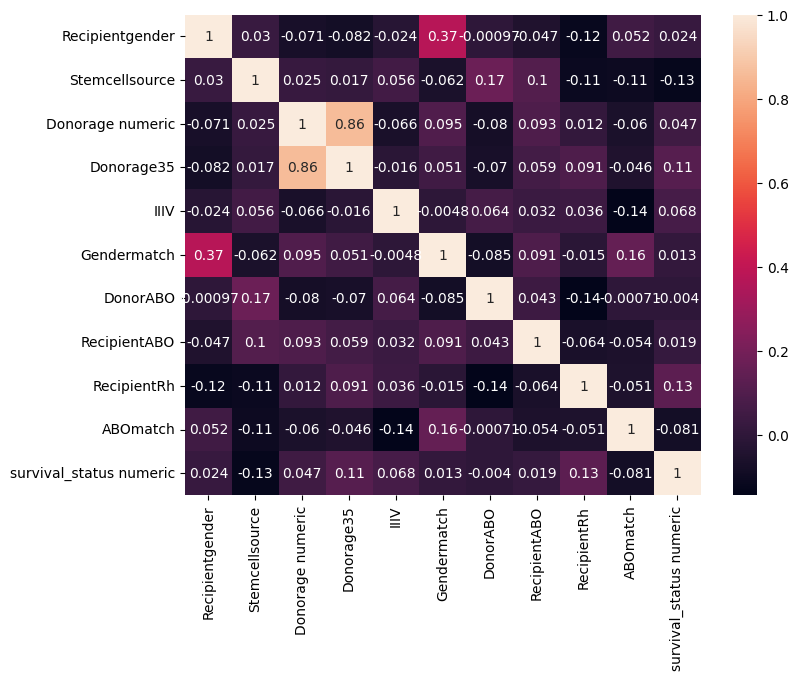

In [15]:
spearman_R = data_corr.corr(method='spearman')
plt.figure(figsize=(6.4 * 1.3, 4.8 * 1.3))
sns.heatmap(spearman_R, annot=True)
plt.show()

In [16]:
def calculateInfoD(col):
    unique = Counter(col)

    total = len(col)
    frequencies = np.array(list(unique.values()), dtype=np.int64)

    p_all = frequencies / total
    infoD = -np.sum(np.multiply(p_all, np.log2(p_all)))
    return infoD

In [17]:
def analysisIG(data_corr, infoD, klasa):
    IG = dict()

    for feature_idx in range(data_corr.shape[1]-1):
        # ovde je Marija skalirala vrednosti kolona nekako ali ne razumem bas sta je tacno tu uradila

        col_values = data_corr.iloc[:, feature_idx]
        
        f = np.unique(col_values)
        infoDA = 0
        for i in f:
            temp = klasa[col_values == i]

            infoDi = calculateInfoD(temp)
            Di = sum(col_values == i)
            D = len(col_values)

            infoDA += Di * infoDi / D
        
        IG[feature_idx] = infoD - infoDA

        print('IG' + str(feature_idx) + ' = ' 'IG(' + data_corr.columns[feature_idx] + ') = ' + str(infoD - infoDA))    
        print('------')
        
    IGsorted = dict(sorted(IG.items(), key=lambda item: item[1]))
    print('Sortirano IG = \n', IGsorted)

    return IGsorted

In [18]:
klasa = data_corr.iloc[:,-1]
infoD = calculateInfoD(klasa)

IGsorted = analysisIG(data_corr, infoD, klasa)

IG0 = IG(Recipientgender) = 0.00041248804242211
------
IG1 = IG(Stemcellsource) = 0.011480699921597504
------
IG2 = IG(Donorage numeric) = 0.9940302114769565
------
IG3 = IG(Donorage35) = 0.00937784655669216
------
IG4 = IG(IIIV) = 0.0033176265497799617
------
IG5 = IG(Gendermatch) = 0.00012104129368917249
------
IG6 = IG(DonorABO) = 0.01199330323187775
------
IG7 = IG(RecipientABO) = 0.0026128131980167613
------
IG8 = IG(RecipientRh) = 0.01269866843063927
------
IG9 = IG(ABOmatch) = 0.004676509383316874
------
Sortirano IG = 
 {5: 0.00012104129368917249, 0: 0.00041248804242211, 7: 0.0026128131980167613, 4: 0.0033176265497799617, 9: 0.004676509383316874, 3: 0.00937784655669216, 1: 0.011480699921597504, 6: 0.01199330323187775, 8: 0.01269866843063927, 2: 0.9940302114769565}


Ono što možemo zaključiti na osnovu vrednosti IG za 10 odabranih obeležja jeste da uzrast donora nosi najveću informaciju, dok preklapanje polova predstavlja najmanje značajan podatak za određivanje klase.

### Analiza nad svim karakteristikama

In [19]:
data_corr = data.drop('survival_status numeric', axis = 1)
data_corr = data_corr.join(data['survival_status numeric'].copy())

In [20]:
klasa = data_corr.iloc[:,-1]
infoD = calculateInfoD(klasa)

IGsorted = analysisIG(data_corr, infoD, klasa)

IG0 = IG(Recipientgender) = 0.00041248804242211
------
IG1 = IG(Stemcellsource) = 0.011480699921597504
------
IG2 = IG(Donorage numeric) = 0.9940302114769565
------
IG3 = IG(Donorage35) = 0.00937784655669216
------
IG4 = IG(IIIV) = 0.0033176265497799617
------
IG5 = IG(Gendermatch) = 0.00012104129368917249
------
IG6 = IG(DonorABO) = 0.01199330323187775
------
IG7 = IG(RecipientABO) = 0.0026128131980167613
------
IG8 = IG(RecipientRh) = 0.01269866843063927
------
IG9 = IG(ABOmatch) = 0.004676509383316874
------
IG10 = IG(CMVstatus) = 0.00805829638734823
------
IG11 = IG(DonorCMV) = 0.002620124005733193
------
IG12 = IG(RecipientCMV) = 0.0035498481808541316
------
IG13 = IG(Disease) = 0.058865886311242344
------
IG14 = IG(Riskgroup) = 0.015736015242410084
------
IG15 = IG(Txpostrelapse) = 0.009675425877970212
------
IG16 = IG(Diseasegroup) = 0.0038445765348088523
------
IG17 = IG(HLAmatch) = 0.002780467756482663
------
IG18 = IG(HLAmismatch) = 4.8563374402621484e-05
------
IG19 = IG(Ant

In [21]:
# top 10 karakterisitka
list(IGsorted.keys())[0:10]

[18, 5, 0, 21, 7, 11, 20, 17, 4, 12]

In [22]:
data_corr_10 = data_corr[data_corr.columns[list(IGsorted.keys())[0:10]]]

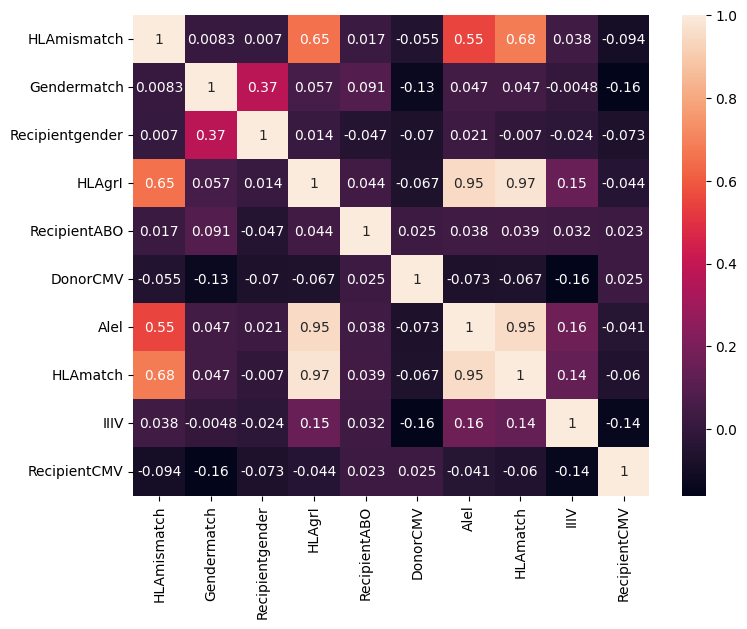

In [23]:
spearman_R = data_corr_10 .corr(method='spearman')
plt.figure(figsize=(6.4 * 1.3, 4.8 * 1.3))
sns.heatmap(spearman_R, annot=True)
plt.show()

Vidi se da je korelisanost fičera Alel i HLAgrl, HLAmatch i HLAgrl, Alel i HLAmatch, kao i HLAmatch i HLAmismatch veoma velika, tako da je potrebno izbaciti neke od njih.

In [24]:
data_corr_10 = data_corr[data_corr.columns[list(IGsorted.keys())[0:13]]]
data_corr_10.drop('Alel', axis = 1, inplace = True)
data_corr_10.drop('HLAgrI', axis = 1, inplace = True)
# kada izbacimo ova dva pojavi se Antigen koji je jako korelisan sa HLAgrI
data_corr_10.drop('Antigen', axis = 1, inplace = True)

C:\Users\jn200100d\AppData\Local\Temp\ipykernel_20136\1614232662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_corr_10.drop('Alel', axis = 1, inplace = True)
C:\Users\jn200100d\AppData\Local\Temp\ipykernel_20136\1614232662.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_corr_10.drop('HLAgrI', axis = 1, inplace = True)
C:\Users\jn200100d\AppData\Local\Temp\ipykernel_20136\1614232662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

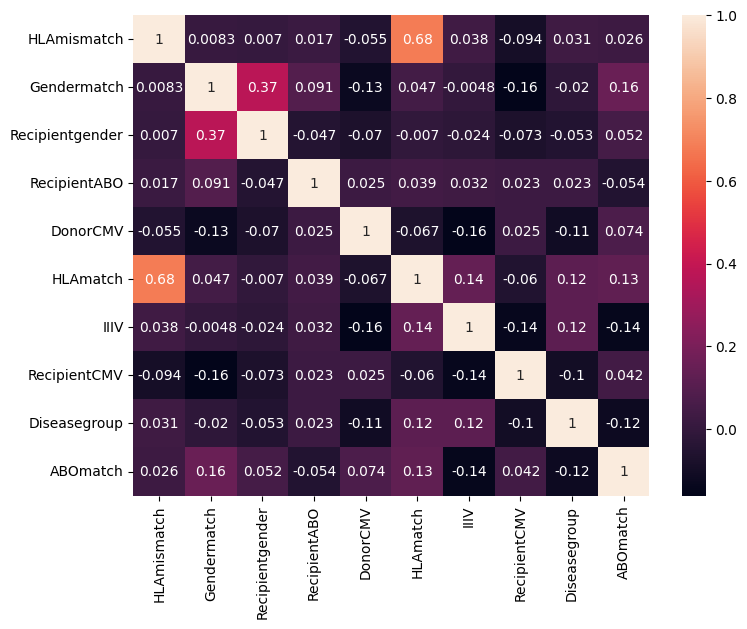

In [25]:
spearman_R = data_corr_10 .corr(method='spearman')
plt.figure(figsize=(6.4 * 1.3, 4.8 * 1.3))
sns.heatmap(spearman_R, annot=True)
plt.show()

Ovakva korelacija i informaciona dobit je korektna za 10 najboljih karakteristika koje bi se kasnije razmatrale. 
   
Analiza PCA I LDA samo nad ovim setom:   
1. LDA daje slične rezultate - mozda za nijansu lošije
2. PCA daje znatno bolje rezultate, mnogo nepotrebnih fičera ga previše zatrpa

# LDA i PCA metode

In [26]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [27]:
X = data.drop('survival_status numeric', axis=1)
D = data['survival_status numeric']

Ovde mozes samo da definises niz kolona koje zelis da normalizujes i onda samo napises recimo X_norm[cols]=(X[cols]-X_mean[cols]) / X_std[cols]

In [202]:
# za analizu sa 10 obeležja
# X_norm = data_corr_10 

X_norm = X 
X_mean = np.mean(X, axis = 0)
X_max = np.max(X, axis = 0)
X_std = np.std(X, axis = 0)
#X_norm = (X - X_mean) / X_max

X_norm['Donorage numeric'] = (X['Donorage numeric'] - X_mean['Donorage numeric']) / X_std['Donorage numeric']
X_norm['Recipientage numeric'] = (X['Recipientage numeric'] - X_mean['Recipientage numeric']) / X_std['Recipientage numeric']
X_norm['CD34kgx10d6 numeric'] = (X['CD34kgx10d6 numeric'] - X_mean['CD34kgx10d6 numeric']) / X_std['CD34kgx10d6 numeric']
X_norm['CD3dCD34 numeric'] = (X['CD3dCD34 numeric'] - X_mean['CD3dCD34 numeric']) / X_std['CD3dCD34 numeric']
X_norm['CD3dkgx10d8 numeric'] = (X['CD3dkgx10d8 numeric'] - X_mean['CD3dkgx10d8 numeric']) / X_std['CD3dkgx10d8 numeric']
X_norm['Rbodymass numeric'] = (X['Rbodymass numeric'] - X_mean['Rbodymass numeric']) / X_std['Rbodymass numeric']
X_norm['ANCrecovery numeric'] = (X['ANCrecovery numeric'] - X_mean['ANCrecovery numeric']) / X_std['ANCrecovery numeric']
X_norm['PLTrecovery numeric'] = (X['PLTrecovery numeric'] - X_mean['PLTrecovery numeric']) / X_std['PLTrecovery numeric']
X_norm['time_to_aGvHD_III_IV numeric'] = (X['time_to_aGvHD_III_IV numeric'] - X_mean['time_to_aGvHD_III_IV numeric']) / X_std['time_to_aGvHD_III_IV numeric']
X_norm['survival_time numeric'] = (X['survival_time numeric'] - X_mean['survival_time numeric']) / X_std['survival_time numeric']
X_norm

,Recipientgender,Stemcellsource,Donorage numeric,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,aGvHDIIIIV,extcGvHD,CD34kgx10d6 numeric,CD3dCD34 numeric,CD3dkgx10d8 numeric,Rbodymass numeric,ANCrecovery numeric,PLTrecovery numeric,time_to_aGvHD_III_IV numeric,survival_time numeric
0,1,1,-1.289981,0,1,0,1,1,1,0,...,0,1,-0.474500,-0.416030,0.194380,-0.033995,-0.165725,-0.316161,-1.858056,0.071115
1,1,0,-1.227878,0,1,0,-1,-1,1,0,...,1,1,-0.747563,0.612866,-1.092887,-0.771055,-0.165744,-0.316209,0.538196,-0.915531
2,1,0,-0.857918,0,1,0,-1,-1,1,0,...,1,1,-0.399661,1.451122,-1.090297,-0.627738,-0.165701,-0.316269,0.538196,-0.594517
3,0,0,0.753104,1,1,0,1,2,1,1,...,0,1,-0.772846,2.557018,-1.162820,0.733775,-0.165701,-0.316237,-1.858087,-1.045353
4,0,1,-0.013717,0,0,0,1,2,0,1,...,1,1,4.041147,-0.137825,2.180969,-1.364798,-0.165756,-0.316289,0.538196,1.303242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,0.497386,1,1,0,1,1,0,0,...,0,1,-0.082099,-0.290952,-0.062037,0.426667,-0.165750,-0.316262,-1.858094,-0.653527
183,0,1,-1.282011,0,0,0,1,0,1,1,...,1,1,-0.733404,-0.447712,-0.041317,0.452259,-0.165769,-0.316234,0.538196,-0.359658
184,0,1,-0.742347,0,1,0,1,-1,1,1,...,1,1,-0.420899,-0.384676,0.026025,-0.136365,-0.165744,-0.316282,0.538196,1.128573
185,1,1,-0.689875,0,1,0,1,0,1,1,...,0,0,0.355813,0.295887,-0.704376,-0.597027,-0.165763,-0.316289,-1.858003,-0.657068


Nema smisla koristiti LDA metodu na sužavanje skupa karakteristika na 2 ili 3 dimenzije jer je maksimalan broj karakteristika koji se može dobiti = min(broj_karakteristika, broj_klasa - 1) = min(36, 2 - 1) = min(36, 1) = 1 => jednodimenzionalna projekcija.    


##### Redukcija PCA na dve dimenzije

In [29]:
pca = PCA(n_components = 2)
data_pca_fcn = pd.DataFrame(pca.fit_transform(X_norm))

data_pca_fcn = pd.concat([data_pca_fcn,D], axis = 1)
data_pca_fcn.columns = ['PCA1', 'PCA2', 'Class']

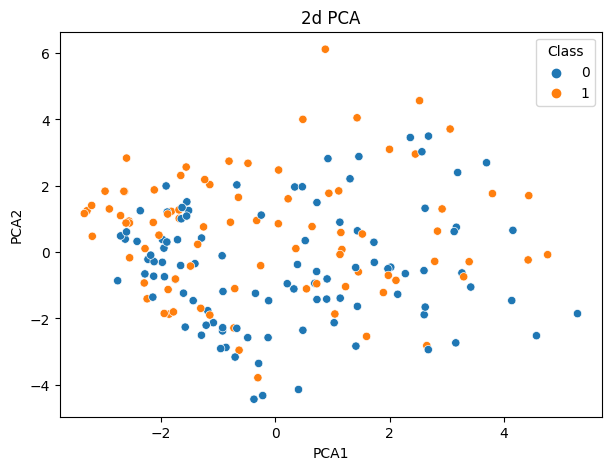

In [30]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data = data_pca_fcn, x = 'PCA1', y = 'PCA2', hue = 'Class')
plt.title('2d PCA')
plt.show()

Uz drugačiju normalizaciju podataka, dobijaju se malo drugačiji rezultati, ali ništa što bi dalo uočljiviju separabilnost klasa.

##### Redukcija LDA na jednu dimenziju

In [31]:
lda = LDA(solver = 'eigen', n_components = 1)
data_lda_fcd = pd.DataFrame(lda.fit_transform(X_norm, D))

data_lda_fcd = pd.concat((data_lda_fcd, D), axis = 1)
data_lda_fcd.columns = ['LDA1', 'Class']

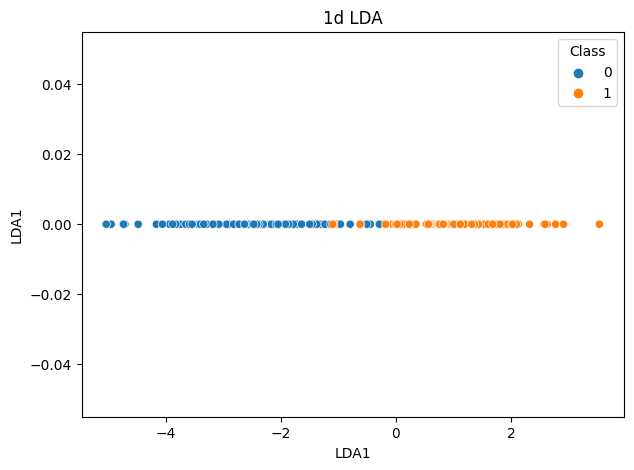

In [32]:
plt.figure(figsize = (7, 5))
sns.scatterplot(x = data_lda_fcd['LDA1'], y = [0]*data_lda_fcd['LDA1'], hue = data_lda_fcd['Class'])
plt.title('1d LDA')
plt.show()

##### Komentar

Pošto je ova baza podataka podeljena na dve klase - preživeli i mrtvi, potrebno je uporediti performanse 1d LDA i 2d PCA metode.     
Sa grafika se može zaključiti da mnogo bolje rezultate daje 1d LDA metoda. Ona se koristi kada nam je potrebno da maksimizujemo separabilnost klasa, oslanjajući se na već postojeće labele; dok je PCA nenadgledana metoda koja se bazira na pronalasku maksimalne varijacije svih podataka u bazi. Ona potencijalno može biti pogodnija ukoliko imamo manji broj odbiraka po klasi, što trenutno nije slučaj.     
Grafici distribucije odbiraka po klasama su prikazani u prethodnim koracima u zavisnosti od korišćene metode.

Analiza PCA i LDA nad setom od 10 najboljih karakterisitka (postupak biranja je opisan u prethodnom koraku) dovodi do vidnog (ali ne i dovoljno dobrog) poboljšanja PCA klasifikatora, dok LDA daje relativno slične rezultate.

# Parametarska klasifikacija

S obzirom da su naši podaci linearno separabilni, primenjujemo linearni klasifikator na bazi željenog izlaza.

<font color=red> OVDE SAM NEŠTO ZEZNULA JUTROS gotov je kod samo sam nešto oko matrica kad sam delila na trening i test set pokvarila kad ispravim javiću ti za sad zanemari i nastavi dalje</font>

In [120]:
x = data_lda_fcd['LDA1']
y = np.array(data_lda_fcd['Class'])

x_c0 = np.array(x[y == 0])
n_0 = np.sum(y == 0)
x_c0 = x_c0.reshape(1, n_0)

x_c1 = np.array(x[y == 1])
n_1 = np.sum(y == 1)
x_c1 = x_c1.reshape(1, n_1)

print(np.ones((1, n_0)).shape)
Z1 = np.matrix(np.append(-x_c0, -np.ones((1, n_0)), axis=0))
print(Z1.shape)
Z2 = np.matrix(np.append(x_c1, -np.ones((1, n_1)), axis=0))
U = np.append(Z1, Z2, axis=1).T
print(U.shape)

U_train, U_test, y_train, y_test = train_test_split(U, y, train_size=2/3, random_state=42, stratify=y)

G = np.matrix(np.ones(y_train.shape[0]))
W = (U_train.T * U_train) ** (-1) * U_train.T * G.T
W = np.asarray(W).T[0]

print(np.array(W))

(1, 102)
(2, 102)
(187, 2)
[ 3.97251676e-16 -1.00000000e+00]


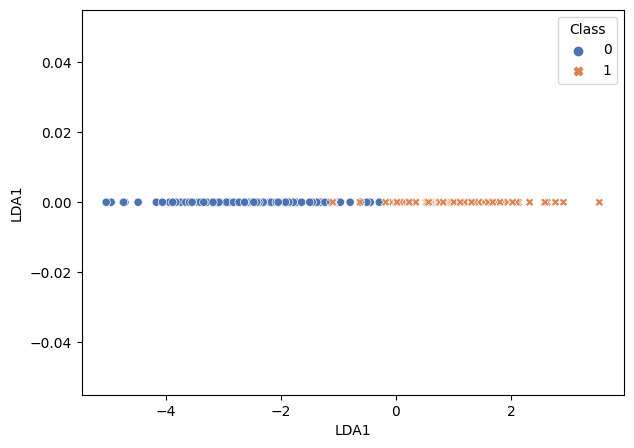

In [142]:
plt.figure(figsize = (7, 5))
sns.scatterplot(x = data_lda_fcd['LDA1'], y = [0]*data_lda_fcd['LDA1'], hue = data_lda_fcd['Class'], style=data_lda_fcd['Class'], palette="deep")
plt.show()

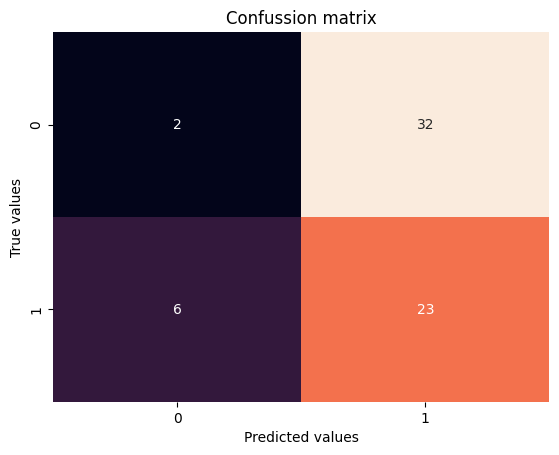

In [141]:
y_pred = W * U_test.T
y_pred = np.asarray(y_pred.T, dtype=int)
y_test = y_test.reshape(y_test.shape[0], 1)

cm = confusion_matrix(y_test, np.asarray(y_pred, dtype=int))
class_labels = ['Class 0', 'Class 1']

plt.figure()
sns.heatmap(cm, annot=True, fmt='g', cbar=False)
plt.title("Confussion matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

# Neparametarska klasifikacija